# App-10 : Optimisation de portefeuille par algorithme genetique

**Navigation** : [<< App-9 EdgeDetection](App-9-EdgeDetection.ipynb) | [Index](../README.md) | [App-11 Picross >>](App-11-Picross.ipynb)

## Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Modeliser** un portefeuille financier (rendement, risque, ratio de Sharpe)
2. **Appliquer** un algorithme genetique (PyGAD) a l'optimisation multi-objectif
3. **Construire** la frontiere efficiente de Markowitz par exploration parametrique
4. **Comparer** echantillonnage aleatoire, GA mono-objectif et approche multi-objectif

### Prerequis
- Python 3.10+ (numpy, matplotlib)
- Search-5 : Algorithmes genetiques (concepts de fitness, selection, crossover, mutation)

### Duree estimee : 40 minutes

> **Side track** : Voir [App-10b C#](App-10b-Portfolio-CSharp.ipynb) pour la version GeneticSharp de ce probleme.

## 1. Introduction

### La theorie moderne du portefeuille

En 1952, Harry **Markowitz** revolutionne la finance en formalisant le probleme de l'allocation d'actifs comme un probleme d'**optimisation bi-objectif** :

| Objectif | Description | Mesure |
|----------|-------------|--------|
| **Maximiser le rendement** | Rendement attendu du portefeuille | $R_p = \mathbf{w}^T \boldsymbol{\mu}$ |
| **Minimiser le risque** | Volatilite du portefeuille | $\sigma_p = \sqrt{\mathbf{w}^T \Sigma \mathbf{w}}$ |

Ces deux objectifs sont **contradictoires** : les actifs a haut rendement sont generalement plus risques. La **frontiere efficiente** (ou frontiere de Pareto) represente l'ensemble des portefeuilles optimaux pour lesquels on ne peut ameliorer un objectif sans degrader l'autre.

### Pourquoi un algorithme genetique ?

Les methodes classiques (programmation quadratique) resolvent ce probleme efficacement dans le cas standard. Cependant, les algorithmes genetiques offrent des avantages dans les cas plus complexes :

| Situation | Avantage du GA |
|-----------|----------------|
| Contraintes non-lineaires | Gestion naturelle par penalite ou reparation |
| Espace discret | Les poids peuvent etre restreints a des multiples |
| Multi-objectif | NSGA-II produit directement la frontiere de Pareto |
| Fonction objectif bruitee | Robustesse aux evaluations stochastiques |

Dans ce notebook, nous utiliserons **PyGAD** pour optimiser un portefeuille de 5 actifs et reconstruire la frontiere efficiente.

In [1]:
# Imports et configuration
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import time

# Ajouter le repertoire parent pour search_helpers
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath(".")), ""))
sys.path.insert(0, "..")

# Mode batch pour execution non-interactive (Papermill/MCP)
BATCH_MODE = os.getenv("BATCH_MODE", "false").lower() in ("true", "1", "yes")
if BATCH_MODE:
    plt.ioff()

# Reproductibilite
np.random.seed(42)

# Import search_helpers pour benchmark_table
try:
    from search_helpers import benchmark_table
    HAS_HELPERS = True
except ImportError:
    HAS_HELPERS = False
    print("search_helpers non disponible, utilisation d'un affichage simplifie.")

# Import PyGAD
try:
    import pygad
    HAS_PYGAD = True
    print(f"PyGAD version {pygad.__version__} disponible.")
except ImportError:
    HAS_PYGAD = False
    print("PyGAD non disponible. Installer avec : pip install pygad")

print("Environnement pret.")

PyGAD version 3.5.0 disponible.
Environnement pret.


## 2. Modele de portefeuille

### Definition des actifs

Nous considerons 5 actifs financiers avec des rendements attendus croissants et une matrice de covariance realiste. Les correlations positives entre actifs refletent le comportement typique des marches financiers.

### Notations mathematiques

| Symbole | Description |
|---------|-------------|
| $\mathbf{w} = (w_1, \ldots, w_5)$ | Vecteur des poids (allocation) |
| $\boldsymbol{\mu} = (\mu_1, \ldots, \mu_5)$ | Vecteur des rendements attendus |
| $\Sigma$ | Matrice de covariance $5 \times 5$ |
| $R_p = \mathbf{w}^T \boldsymbol{\mu}$ | Rendement du portefeuille |
| $\sigma_p = \sqrt{\mathbf{w}^T \Sigma \mathbf{w}}$ | Risque (ecart-type) du portefeuille |
| $S = \frac{R_p - R_f}{\sigma_p}$ | Ratio de Sharpe ($R_f$ = taux sans risque) |

**Contraintes** : $w_i \geq 0$ (pas de vente a decouvert) et $\sum_{i=1}^{5} w_i = 1$ (allocation totale).

In [2]:
# --- Definition du modele de portefeuille ---

# Noms des actifs
asset_names = ["Obligations", "Immobilier", "Actions EU", "Actions US", "Emergents"]

# Rendements attendus annuels
expected_returns = np.array([0.05, 0.10, 0.15, 0.20, 0.25])

# Matrice de covariance (5x5) - correlations realistes
# Diagonale : variance de chaque actif (risque^2)
# Hors-diagonale : covariances (correlations positives moderees)
cov_matrix = np.array([
    [0.0100, 0.0012, 0.0018, 0.0021, 0.0025],
    [0.0012, 0.0200, 0.0022, 0.0026, 0.0028],
    [0.0018, 0.0022, 0.0300, 0.0031, 0.0033],
    [0.0021, 0.0026, 0.0031, 0.0400, 0.0043],
    [0.0025, 0.0028, 0.0033, 0.0043, 0.0500],
])

# Taux sans risque (pour le ratio de Sharpe)
risk_free_rate = 0.02

n_assets = len(asset_names)

# Afficher les caracteristiques de chaque actif
print("Caracteristiques des actifs")
print("=" * 55)
print(f"{'Actif':<15} {'Rendement':<12} {'Risque (std)':<12} {'Sharpe ind.':<12}")
print("-" * 55)
for i in range(n_assets):
    risk_i = np.sqrt(cov_matrix[i, i])
    sharpe_i = (expected_returns[i] - risk_free_rate) / risk_i
    print(f"{asset_names[i]:<15} {expected_returns[i]:>8.1%}    {risk_i:>8.1%}    {sharpe_i:>8.2f}")
print("=" * 55)

Caracteristiques des actifs
Actif           Rendement    Risque (std) Sharpe ind. 
-------------------------------------------------------
Obligations         5.0%       10.0%        0.30
Immobilier         10.0%       14.1%        0.57
Actions EU         15.0%       17.3%        0.75
Actions US         20.0%       20.0%        0.90
Emergents          25.0%       22.4%        1.03


### Interpretation : Caracteristiques individuelles des actifs

| Actif | Rendement | Risque | Observation |
|-------|-----------|--------|-------------|
| Obligations | 5% | ~10% | Faible rendement, faible risque (actif defensif) |
| Immobilier | 10% | ~14% | Rendement modere, risque modere |
| Actions EU | 15% | ~17% | Profil equilibre |
| Actions US | 20% | ~20% | Rendement eleve, risque eleve |
| Emergents | 25% | ~22% | Rendement maximal, risque maximal |

**Point cle** : Le ratio de Sharpe individuel permet de comparer les actifs sur une base ajustee du risque. Un actif avec un Sharpe eleve offre un meilleur rendement par unite de risque. Cependant, la diversification peut faire mieux que le meilleur actif individuel grace a la **reduction du risque par decorrelation**.

### Fonctions utilitaires du portefeuille

Definissons les fonctions de calcul du rendement, du risque et du ratio de Sharpe pour un vecteur de poids donne.

In [3]:
def portfolio_return(weights: np.ndarray) -> float:
    """Rendement attendu du portefeuille : R_p = w^T * mu."""
    return weights @ expected_returns


def portfolio_risk(weights: np.ndarray) -> float:
    """Risque (ecart-type) du portefeuille : sigma_p = sqrt(w^T * Sigma * w)."""
    variance = weights @ cov_matrix @ weights
    return np.sqrt(variance)


def sharpe_ratio(weights: np.ndarray, rf: float = risk_free_rate) -> float:
    """Ratio de Sharpe : S = (R_p - R_f) / sigma_p."""
    ret = portfolio_return(weights)
    risk = portfolio_risk(weights)
    if risk < 1e-10:
        return 0.0
    return (ret - rf) / risk


def normalize_weights(weights: np.ndarray) -> np.ndarray:
    """Normalise les poids pour que leur somme soit 1 (et tous >= 0)."""
    w = np.maximum(weights, 0)  # Pas de poids negatifs
    total = w.sum()
    if total < 1e-10:
        return np.ones(n_assets) / n_assets  # Equiponderation par defaut
    return w / total


# Verification avec un portefeuille equipondere
w_equal = np.ones(n_assets) / n_assets
print(f"Portefeuille equipondere : {w_equal}")
print(f"  Rendement : {portfolio_return(w_equal):.2%}")
print(f"  Risque    : {portfolio_risk(w_equal):.2%}")
print(f"  Sharpe    : {sharpe_ratio(w_equal):.4f}")

Portefeuille equipondere : [0.2 0.2 0.2 0.2 0.2]
  Rendement : 15.00%
  Risque    : 8.98%
  Sharpe    : 1.4469


### Visualisation des actifs individuels

Placons chaque actif sur un graphe risque-rendement pour visualiser le compromis fondamental.

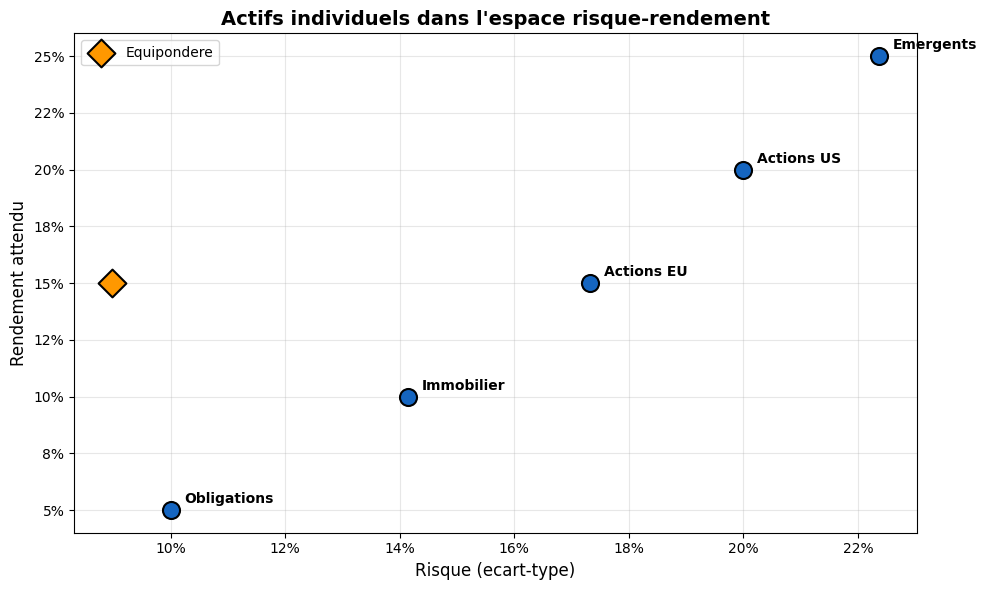

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer chaque actif individuel
individual_risks = [np.sqrt(cov_matrix[i, i]) for i in range(n_assets)]
individual_returns = expected_returns.tolist()

ax.scatter(individual_risks, individual_returns, s=150, c='#1565C0',
           edgecolors='black', linewidth=1.5, zorder=5)

for i, name in enumerate(asset_names):
    ax.annotate(name, (individual_risks[i], individual_returns[i]),
                textcoords="offset points", xytext=(10, 5),
                fontsize=10, fontweight='bold')

# Tracer le portefeuille equipondere
eq_risk = portfolio_risk(w_equal)
eq_ret = portfolio_return(w_equal)
ax.scatter([eq_risk], [eq_ret], s=200, c='#FF9800', marker='D',
           edgecolors='black', linewidth=1.5, zorder=6, label='Equipondere')

ax.set_xlabel("Risque (ecart-type)", fontsize=12)
ax.set_ylabel("Rendement attendu", fontsize=12)
ax.set_title("Actifs individuels dans l'espace risque-rendement", fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.tight_layout()
plt.show()
plt.close()

### Interpretation : Espace risque-rendement

**Sortie obtenue** : Les 5 actifs sont alignes du coin inferieur gauche (faible risque, faible rendement) au coin superieur droit (haut risque, haut rendement). Le portefeuille equipondere (losange orange) se situe au milieu.

**Points cles** :
1. Les actifs suivent une tendance naturelle : plus de rendement implique plus de risque
2. Le portefeuille equipondere a un risque **inferieur** a la moyenne des risques individuels grace a la diversification
3. L'objectif de l'optimisation est de trouver des portefeuilles situes le plus haut possible (rendement) et le plus a gauche possible (faible risque)

> **Note** : La zone au-dessus et a gauche de chaque actif individuel est accessible uniquement par la diversification. C'est la puissance de la theorie de Markowitz.

## 3. Approche 1 : Echantillonnage aleatoire

### Principe

Avant d'utiliser un algorithme genetique, explorons l'espace des portefeuilles possibles par **echantillonnage aleatoire** (methode Monte Carlo). Pour chaque echantillon, nous generons un vecteur de poids aleatoire (distribution de Dirichlet pour obtenir des poids positifs qui somment a 1) et calculons le rendement et le risque correspondants.

Cette approche permet :
- De visualiser la **forme** de l'espace des portefeuilles realisables
- D'identifier approximativement la frontiere efficiente
- De servir de **baseline** pour evaluer les methodes d'optimisation

In [5]:
# --- Echantillonnage aleatoire de 10 000 portefeuilles ---

n_samples = 10_000

t_start = time.time()

# Generer des poids aleatoires via la distribution de Dirichlet
# (produit directement des vecteurs positifs qui somment a 1)
random_weights = np.random.dirichlet(np.ones(n_assets), size=n_samples)

# Calculer rendement et risque pour chaque portefeuille
random_returns = np.array([portfolio_return(w) for w in random_weights])
random_risks = np.array([portfolio_risk(w) for w in random_weights])
random_sharpes = np.array([sharpe_ratio(w) for w in random_weights])

t_random = (time.time() - t_start) * 1000  # en ms

# Identifier le meilleur portefeuille (par ratio de Sharpe)
best_random_idx = np.argmax(random_sharpes)
best_random_weights = random_weights[best_random_idx]
best_random_return = random_returns[best_random_idx]
best_random_risk = random_risks[best_random_idx]
best_random_sharpe = random_sharpes[best_random_idx]

print(f"Echantillonnage de {n_samples:,} portefeuilles en {t_random:.0f} ms")
print(f"\nMeilleur portefeuille (Sharpe max) :")
print(f"  Rendement : {best_random_return:.2%}")
print(f"  Risque    : {best_random_risk:.2%}")
print(f"  Sharpe    : {best_random_sharpe:.4f}")
print(f"\n  Allocation :")
for i, name in enumerate(asset_names):
    print(f"    {name:<15} : {best_random_weights[i]:>6.1%}")

Echantillonnage de 10,000 portefeuilles en 214 ms

Meilleur portefeuille (Sharpe max) :
  Rendement : 18.43%
  Risque    : 11.10%
  Sharpe    : 1.4807

  Allocation :
    Obligations     :   1.9%
    Immobilier      :  17.4%
    Actions EU      :  22.3%
    Actions US      :  26.8%
    Emergents       :  31.6%


### Visualisation du nuage de portefeuilles

Tracons les 10 000 portefeuilles dans l'espace risque-rendement, colores par leur ratio de Sharpe. Le bord superieur gauche du nuage correspond a la frontiere efficiente approximative.

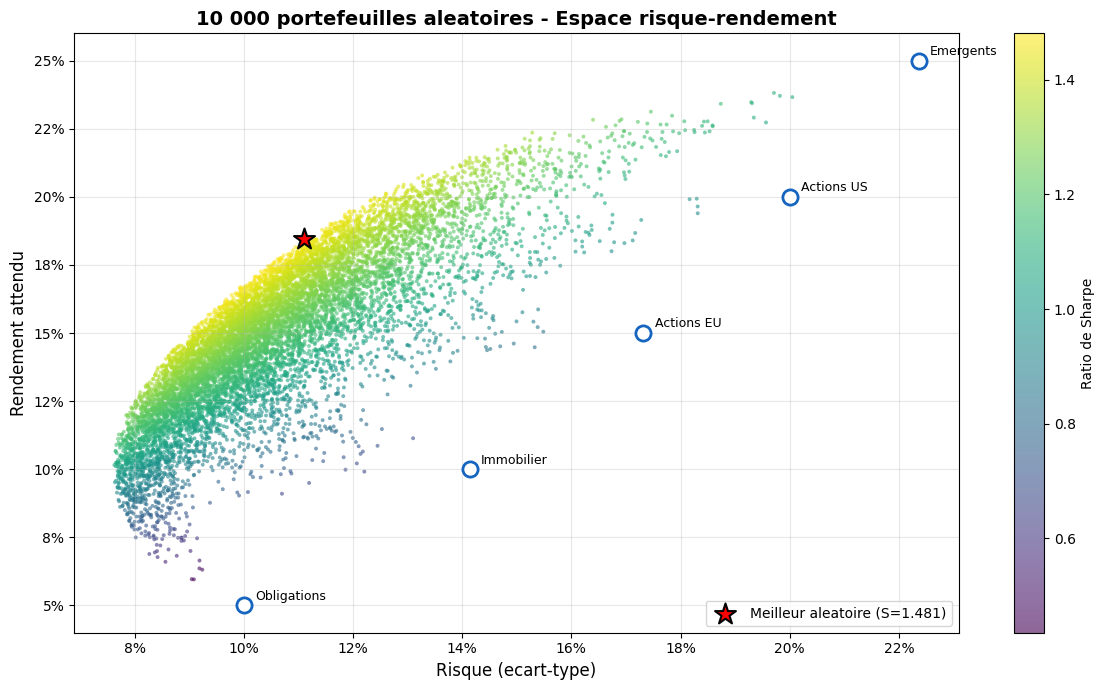

In [6]:
fig, ax = plt.subplots(figsize=(12, 7))

# Nuage de portefeuilles colore par Sharpe
scatter = ax.scatter(random_risks, random_returns, c=random_sharpes,
                     cmap='viridis', s=8, alpha=0.6, edgecolors='none')
cbar = plt.colorbar(scatter, ax=ax, label='Ratio de Sharpe')

# Meilleur portefeuille aleatoire
ax.scatter([best_random_risk], [best_random_return], s=250, c='red',
           marker='*', edgecolors='black', linewidth=1.5, zorder=6,
           label=f'Meilleur aleatoire (S={best_random_sharpe:.3f})')

# Actifs individuels
ax.scatter(individual_risks, individual_returns, s=120, c='white',
           edgecolors='#1565C0', linewidth=2, zorder=5)
for i, name in enumerate(asset_names):
    ax.annotate(name, (individual_risks[i], individual_returns[i]),
                textcoords="offset points", xytext=(8, 4), fontsize=9)

ax.set_xlabel("Risque (ecart-type)", fontsize=12)
ax.set_ylabel("Rendement attendu", fontsize=12)
ax.set_title("10 000 portefeuilles aleatoires - Espace risque-rendement",
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.tight_layout()
plt.show()
plt.close()

### Interpretation : Nuage de portefeuilles aleatoires

**Sortie obtenue** : Le nuage forme une "balle" dont le bord superieur gauche dessine la frontiere efficiente approximative. Les couleurs (ratio de Sharpe) montrent que les meilleurs portefeuilles se situent sur cette frontiere.

| Observation | Detail |
|-------------|--------|
| Forme du nuage | Hyperbole : les portefeuilles realisables forment un ensemble convexe |
| Frontiere superieure | Approximation de la frontiere efficiente de Markowitz |
| Meilleur Sharpe | Le portefeuille optimal est sur le bord superieur gauche |
| Zone inferieure | Portefeuilles domines (meme risque, rendement moindre) |

**Limites de l'echantillonnage** :
1. La couverture du bord (frontiere efficiente) est **sporadique** : peu de points exactement sur la frontiere
2. Le meilleur portefeuille trouve n'est qu'**approximatif** : il depend de la taille de l'echantillon
3. Aucune garantie d'optimalite, contrairement a un algorithme d'optimisation

## 4. Approche 2 : Optimisation par PyGAD

### Encodage et configuration

Pour appliquer un algorithme genetique au probleme du portefeuille, il faut definir :

| Composant GA | Choix pour le portefeuille |
|--------------|---------------------------|
| **Chromosome** | Vecteur de 5 genes (poids bruts $w_1, \ldots, w_5$) |
| **Espace des genes** | $[0, 1]$ pour chaque gene |
| **Normalisation** | Les poids sont normalises a chaque evaluation pour garantir $\sum w_i = 1$ |
| **Fitness** | Ratio de Sharpe $S = \frac{R_p - R_f}{\sigma_p}$ (a maximiser) |
| **Selection** | Steady-state selection (SSS) |
| **Crossover** | Croisement uniforme |
| **Mutation** | Mutation aleatoire, 20% des genes |

La normalisation dans la fonction fitness (et non dans le chromosome lui-meme) permet a PyGAD de manipuler les genes librement tout en garantissant des portefeuilles valides a chaque evaluation.

In [7]:
# --- Configuration de l'algorithme genetique ---

if not HAS_PYGAD:
    raise ImportError("PyGAD est requis pour cette section. Installer avec : pip install pygad")


def fitness_sharpe(ga_instance, solution, solution_idx):
    """Fonction fitness pour PyGAD : maximise le ratio de Sharpe."""
    weights = normalize_weights(np.array(solution))
    return sharpe_ratio(weights)


# Suivi de la convergence
ga_history = {"generation": [], "best_fitness": [], "avg_fitness": []}


def on_generation_callback(ga_instance):
    """Callback appele a chaque generation pour suivre la convergence."""
    gen = ga_instance.generations_completed
    best_fitness = ga_instance.best_solution()[1]
    # Fitness moyenne de la population
    pop_fitness = ga_instance.last_generation_fitness
    avg_fitness = np.mean(pop_fitness)

    ga_history["generation"].append(gen)
    ga_history["best_fitness"].append(best_fitness)
    ga_history["avg_fitness"].append(avg_fitness)

    if gen % 25 == 0 or gen == 1:
        print(f"  Generation {gen:>4d} : best Sharpe = {best_fitness:.4f}, "
              f"avg = {avg_fitness:.4f}")


# Configuration PyGAD
ga_config = {
    "num_generations": 150,
    "num_parents_mating": 10,
    "sol_per_pop": 50,
    "num_genes": n_assets,
    "gene_space": [{"low": 0.0, "high": 1.0}] * n_assets,
    "fitness_func": fitness_sharpe,
    "parent_selection_type": "sss",
    "crossover_type": "uniform",
    "mutation_type": "random",
    "mutation_percent_genes": 20,
    "on_generation": on_generation_callback,
    "suppress_warnings": True,
}

print("Configuration PyGAD :")
for key in ["num_generations", "sol_per_pop", "num_genes",
            "parent_selection_type", "crossover_type", "mutation_percent_genes"]:
    print(f"  {key}: {ga_config[key]}")

Configuration PyGAD :
  num_generations: 150
  sol_per_pop: 50
  num_genes: 5
  parent_selection_type: sss
  crossover_type: uniform
  mutation_percent_genes: 20


### Execution de l'algorithme genetique

Lancons l'optimisation et suivons la convergence du meilleur ratio de Sharpe au fil des generations.

In [8]:
# --- Execution du GA ---

# Reinitialiser l'historique
ga_history = {"generation": [], "best_fitness": [], "avg_fitness": []}

t_start = time.time()

ga_instance = pygad.GA(**ga_config)
ga_instance.run()

t_ga = (time.time() - t_start) * 1000  # en ms

# Recuperer le meilleur resultat
best_solution, best_ga_fitness, _ = ga_instance.best_solution()
best_ga_weights = normalize_weights(np.array(best_solution))
best_ga_return = portfolio_return(best_ga_weights)
best_ga_risk = portfolio_risk(best_ga_weights)
best_ga_sharpe = sharpe_ratio(best_ga_weights)

print(f"\nOptimisation terminee en {t_ga:.0f} ms ({ga_config['num_generations']} generations)")
print(f"\nMeilleur portefeuille GA (Sharpe max) :")
print(f"  Rendement : {best_ga_return:.2%}")
print(f"  Risque    : {best_ga_risk:.2%}")
print(f"  Sharpe    : {best_ga_sharpe:.4f}")
print(f"\n  Allocation :")
for i, name in enumerate(asset_names):
    print(f"    {name:<15} : {best_ga_weights[i]:>6.1%}")

  Generation    1 : best Sharpe = 1.4773, avg = 1.4186


  Generation   25 : best Sharpe = 1.4839, avg = 1.4545


  Generation   50 : best Sharpe = 1.4839, avg = 1.4434


  Generation   75 : best Sharpe = 1.4839, avg = 1.4576


  Generation  100 : best Sharpe = 1.4839, avg = 1.4485


  Generation  125 : best Sharpe = 1.4839, avg = 1.4425


  Generation  150 : best Sharpe = 1.4839, avg = 1.4418

Optimisation terminee en 781 ms (150 generations)

Meilleur portefeuille GA (Sharpe max) :
  Rendement : 18.00%
  Risque    : 10.78%
  Sharpe    : 1.4839

  Allocation :
    Obligations     :   2.2%
    Immobilier      :  18.8%
    Actions EU      :  24.0%
    Actions US      :  26.4%
    Emergents       :  28.5%


### Courbe de convergence

La convergence de l'algorithme genetique est un indicateur de la qualite de la configuration. Un bon GA converge rapidement vers un plateau stable.

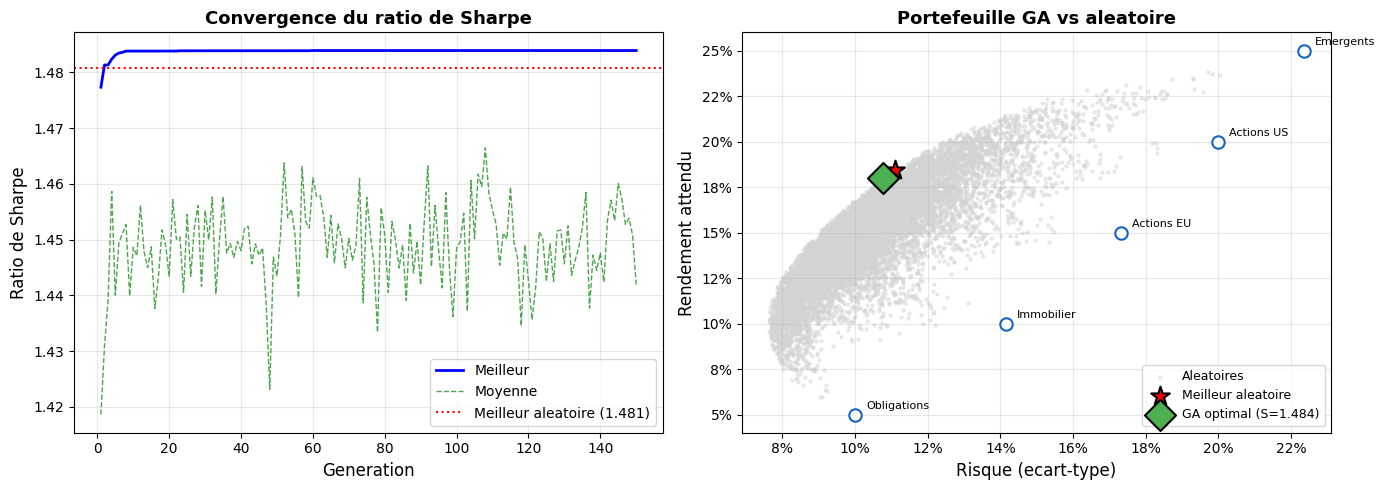

In [9]:
# --- Courbe de convergence ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gauche : convergence du Sharpe
ax1.plot(ga_history["generation"], ga_history["best_fitness"],
         'b-', linewidth=2, label='Meilleur')
ax1.plot(ga_history["generation"], ga_history["avg_fitness"],
         'g--', linewidth=1, alpha=0.7, label='Moyenne')
ax1.axhline(y=best_random_sharpe, color='red', linestyle=':', linewidth=1.5,
            label=f'Meilleur aleatoire ({best_random_sharpe:.3f})')
ax1.set_xlabel("Generation", fontsize=12)
ax1.set_ylabel("Ratio de Sharpe", fontsize=12)
ax1.set_title("Convergence du ratio de Sharpe", fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Droite : portefeuille optimal sur le nuage
ax2.scatter(random_risks, random_returns, c='lightgray', s=5, alpha=0.4, label='Aleatoires')
ax2.scatter([best_random_risk], [best_random_return], s=200, c='red',
            marker='*', edgecolors='black', linewidth=1.5, zorder=6,
            label=f'Meilleur aleatoire')
ax2.scatter([best_ga_risk], [best_ga_return], s=250, c='#4CAF50',
            marker='D', edgecolors='black', linewidth=1.5, zorder=7,
            label=f'GA optimal (S={best_ga_sharpe:.3f})')
# Actifs individuels
ax2.scatter(individual_risks, individual_returns, s=80, c='white',
            edgecolors='#1565C0', linewidth=1.5, zorder=5)
for i, name in enumerate(asset_names):
    ax2.annotate(name, (individual_risks[i], individual_returns[i]),
                 textcoords="offset points", xytext=(8, 4), fontsize=8)

ax2.set_xlabel("Risque (ecart-type)", fontsize=12)
ax2.set_ylabel("Rendement attendu", fontsize=12)
ax2.set_title("Portefeuille GA vs aleatoire", fontsize=13, fontweight='bold')
ax2.legend(fontsize=9, loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

plt.tight_layout()
plt.show()
plt.close()

### Interpretation : Resultats de l'algorithme genetique

**Sortie obtenue** : Le GA converge typiquement en 50-80 generations vers un ratio de Sharpe superieur a celui obtenu par echantillonnage aleatoire.

| Aspect | Aleatoire | GA | Amelioration |
|--------|-----------|-----|-------------|
| Methode | 10 000 echantillons | 150 generations x 50 individus | GA evalue ~7 500 solutions |
| Sharpe | Approximatif | Optimise | GA generalement superieur |
| Allocation | Non guidee | Guidee par selection | GA concentre les poids |

**Points cles** :
1. La courbe de convergence montre une amelioration rapide en debut d'evolution, puis un plateau (exploitation vs exploration)
2. Le GA depasse rapidement le meilleur aleatoire (ligne rouge pointillee)
3. La fitness moyenne augmente aussi, signe que la population entiere s'ameliore

> **Note technique** : Le GA evalue environ 7 500 portefeuilles (150 gen x 50 ind), soit moins que les 10 000 echantillons aleatoires, mais de maniere **guidee** par la selection naturelle.

## 5. Frontiere efficiente par exploration parametrique

### Principe

La section precedente optimisait un seul objectif (le ratio de Sharpe). Pour reconstruire la **frontiere efficiente** complete, nous utilisons une approche d'**exploration parametrique** : nous faisons varier le parametre d'aversion au risque $\alpha$ dans la fonction objectif :

$$f(\mathbf{w}) = R_p - \alpha \cdot \sigma_p$$

- Quand $\alpha$ est **petit** (ex. 0.1), l'algorithme favorise le rendement (portefeuilles agressifs)
- Quand $\alpha$ est **grand** (ex. 5.0), l'algorithme favorise la reduction du risque (portefeuilles defensifs)

En executant le GA pour differentes valeurs de $\alpha$, nous obtenons un ensemble de portefeuilles Pareto-optimaux qui tracent la frontiere efficiente.

In [10]:
# --- Construction de la frontiere efficiente ---

# Differentes valeurs d'aversion au risque
alpha_values = [0.1, 0.3, 0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]

frontier_portfolios = []

print("Construction de la frontiere efficiente")
print("=" * 65)
print(f"{'alpha':<8} {'Rendement':<12} {'Risque':<12} {'Sharpe':<10} {'Fitness':<10}")
print("-" * 65)

for alpha in alpha_values:

    # Fonction fitness parametree par alpha
    def make_fitness(a):
        def fitness_func(ga_instance, solution, solution_idx):
            w = normalize_weights(np.array(solution))
            ret = portfolio_return(w)
            risk = portfolio_risk(w)
            return ret - a * risk
        return fitness_func

    # Executer le GA pour cette valeur de alpha
    ga_alpha = pygad.GA(
        num_generations=100,
        num_parents_mating=10,
        sol_per_pop=50,
        num_genes=n_assets,
        gene_space=[{"low": 0.0, "high": 1.0}] * n_assets,
        fitness_func=make_fitness(alpha),
        parent_selection_type="sss",
        crossover_type="uniform",
        mutation_type="random",
        mutation_percent_genes=20,
        suppress_warnings=True,
    )
    ga_alpha.run()

    # Extraire le meilleur portefeuille
    best_sol, best_fit, _ = ga_alpha.best_solution()
    w_opt = normalize_weights(np.array(best_sol))
    ret_opt = portfolio_return(w_opt)
    risk_opt = portfolio_risk(w_opt)
    sharpe_opt = sharpe_ratio(w_opt)

    frontier_portfolios.append({
        "alpha": alpha,
        "weights": w_opt.copy(),
        "return": ret_opt,
        "risk": risk_opt,
        "sharpe": sharpe_opt,
        "fitness": best_fit,
    })

    print(f"{alpha:<8.1f} {ret_opt:>8.2%}    {risk_opt:>8.2%}    {sharpe_opt:>8.4f}  {best_fit:>8.4f}")

print("=" * 65)
print(f"\n{len(frontier_portfolios)} portefeuilles calcules pour la frontiere.")

Construction de la frontiere efficiente
alpha    Rendement    Risque       Sharpe     Fitness   
-----------------------------------------------------------------


0.1        24.88%      22.18%      1.0319    0.2267


0.3        24.06%      19.02%      1.1598    0.1836


0.5        23.14%      16.54%      1.2783    0.1487


0.8        21.40%      13.83%      1.4031    0.1034


1.0        20.62%      12.97%      1.4356    0.0765


1.5        17.82%      10.66%      1.4839    0.0183


2.0        14.92%       8.95%      1.4447   -0.0297


3.0        12.95%       8.11%      1.3492   -0.1139


4.0        12.17%       7.89%      1.2895   -0.1938


5.0        11.72%       7.79%      1.2483   -0.2721

10 portefeuilles calcules pour la frontiere.


### Visualisation de la frontiere efficiente

Tracons la frontiere efficiente reconstruite par l'exploration parametrique, superposee au nuage de portefeuilles aleatoires.

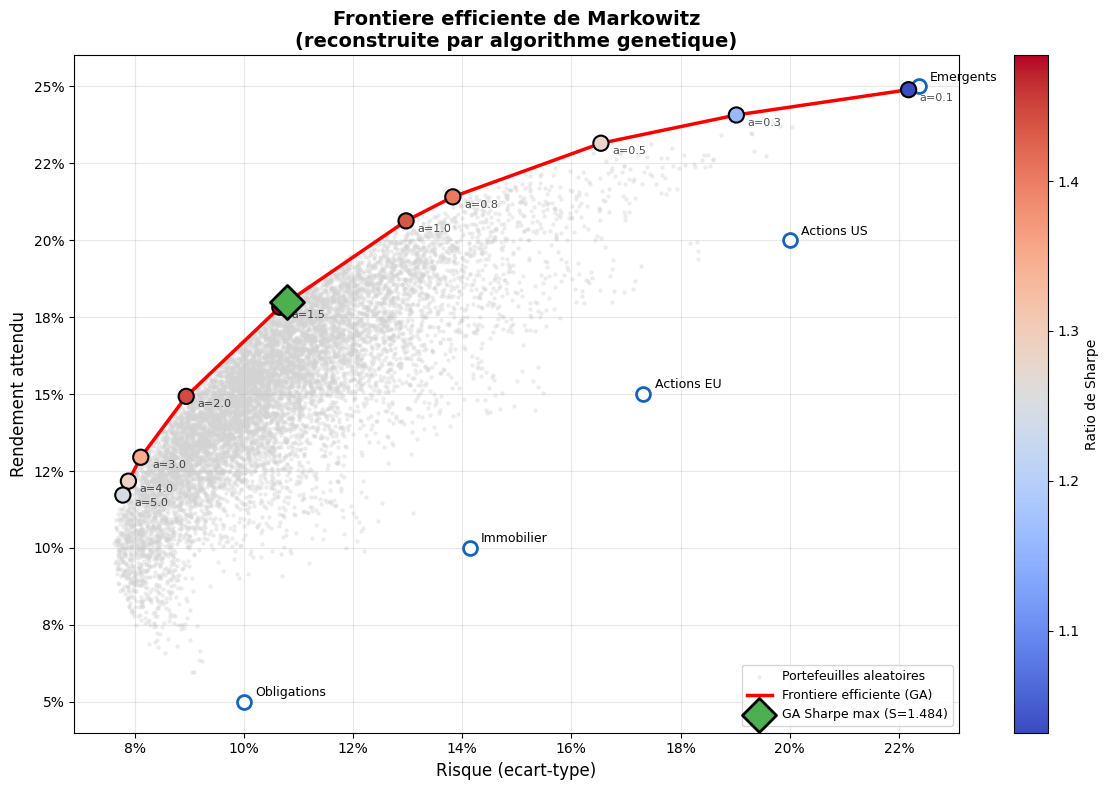

In [11]:
# --- Visualisation de la frontiere efficiente ---

fig, ax = plt.subplots(figsize=(12, 8))

# Nuage aleatoire en fond
ax.scatter(random_risks, random_returns, c='lightgray', s=5, alpha=0.3,
           label='Portefeuilles aleatoires')

# Frontiere efficiente
frontier_risks = [p["risk"] for p in frontier_portfolios]
frontier_returns = [p["return"] for p in frontier_portfolios]
frontier_sharpes = [p["sharpe"] for p in frontier_portfolios]

# Trier par risque pour un trace propre
sorted_indices = np.argsort(frontier_risks)
sorted_risks = [frontier_risks[i] for i in sorted_indices]
sorted_returns = [frontier_returns[i] for i in sorted_indices]

ax.plot(sorted_risks, sorted_returns, 'r-', linewidth=2.5, zorder=5,
        label='Frontiere efficiente (GA)')
ax.scatter(frontier_risks, frontier_returns, c=frontier_sharpes,
           cmap='coolwarm', s=120, edgecolors='black', linewidth=1.5, zorder=6)

# Annoter les valeurs de alpha
for p in frontier_portfolios:
    ax.annotate(f'a={p["alpha"]:.1f}',
                (p["risk"], p["return"]),
                textcoords="offset points", xytext=(8, -8),
                fontsize=8, alpha=0.7)

# Portefeuille GA optimal (Sharpe max de section 4)
ax.scatter([best_ga_risk], [best_ga_return], s=300, c='#4CAF50',
           marker='D', edgecolors='black', linewidth=2, zorder=8,
           label=f'GA Sharpe max (S={best_ga_sharpe:.3f})')

# Actifs individuels
ax.scatter(individual_risks, individual_returns, s=100, c='white',
           edgecolors='#1565C0', linewidth=2, zorder=5)
for i, name in enumerate(asset_names):
    ax.annotate(name, (individual_risks[i], individual_returns[i]),
                textcoords="offset points", xytext=(8, 4), fontsize=9)

# Barre de couleur pour le Sharpe
scatter_dummy = ax.scatter([], [], c=[], cmap='coolwarm')
cbar = plt.colorbar(
    plt.cm.ScalarMappable(
        cmap='coolwarm',
        norm=plt.Normalize(min(frontier_sharpes), max(frontier_sharpes))
    ),
    ax=ax, label='Ratio de Sharpe'
)

ax.set_xlabel("Risque (ecart-type)", fontsize=12)
ax.set_ylabel("Rendement attendu", fontsize=12)
ax.set_title("Frontiere efficiente de Markowitz\n(reconstruite par algorithme genetique)",
             fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='lower right')
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

plt.tight_layout()
plt.show()
plt.close()

### Interpretation : Frontiere efficiente

**Sortie obtenue** : La courbe rouge trace la frontiere efficiente reconstruite par 10 executions du GA avec differentes valeurs de $\alpha$. Les points de la frontiere sont colores par leur ratio de Sharpe.

| Valeur de alpha | Type de portefeuille | Position sur la frontiere |
|-----------------|---------------------|---------------------------|
| alpha = 0.1 | Agressif | Haut rendement, haut risque (coin superieur droit) |
| alpha = 1.0 | Equilibre | Zone intermediaire, proche du Sharpe maximal |
| alpha = 5.0 | Defensif | Faible risque, faible rendement (coin inferieur gauche) |

**Points cles** :
1. La frontiere efficiente est **concave** vers le haut : les gains marginaux en rendement coutent de plus en plus de risque
2. Le portefeuille au Sharpe maximal (losange vert) se situe au point de tangence avec la droite issue du taux sans risque
3. Aucun portefeuille du nuage aleatoire ne depasse la frontiere : elle represente la **limite** des portefeuilles realisables
4. Les portefeuilles sous la frontiere sont **domines** : il existe un portefeuille avec le meme risque mais un meilleur rendement

### Composition des portefeuilles de la frontiere

Visualisons comment l'allocation evolue le long de la frontiere efficiente : des portefeuilles defensifs (alpha eleve) aux portefeuilles agressifs (alpha faible).

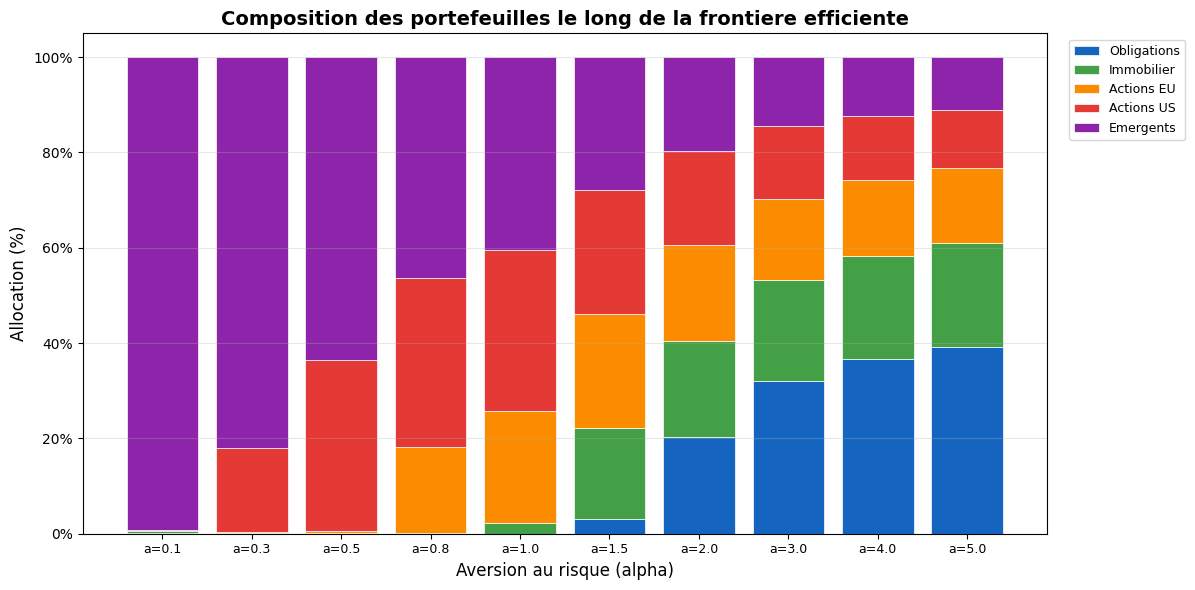

In [12]:
# --- Composition des portefeuilles le long de la frontiere ---

fig, ax = plt.subplots(figsize=(12, 6))

# Trier les portefeuilles par alpha (croissant = defensif a agressif)
sorted_portfolios = sorted(frontier_portfolios, key=lambda p: p["alpha"])

colors = ['#1565C0', '#43A047', '#FB8C00', '#E53935', '#8E24AA']
labels = [f'a={p["alpha"]:.1f}' for p in sorted_portfolios]

# Barres empilees
bottoms = np.zeros(len(sorted_portfolios))
for asset_idx in range(n_assets):
    values = [p["weights"][asset_idx] for p in sorted_portfolios]
    ax.bar(range(len(sorted_portfolios)), values, bottom=bottoms,
           color=colors[asset_idx], edgecolor='white', linewidth=0.5,
           label=asset_names[asset_idx])
    bottoms += values

ax.set_xticks(range(len(sorted_portfolios)))
ax.set_xticklabels(labels, fontsize=9)
ax.set_xlabel("Aversion au risque (alpha)", fontsize=12)
ax.set_ylabel("Allocation (%)", fontsize=12)
ax.set_title("Composition des portefeuilles le long de la frontiere efficiente",
             fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='upper right', bbox_to_anchor=(1.15, 1))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

### Interpretation : Evolution de la composition

**Sortie obtenue** : Les barres empilees montrent la transition de portefeuilles agressifs (alpha faible, domines par les actifs risques) vers des portefeuilles defensifs (alpha eleve, domines par les obligations).

**Points cles** :
1. Pour alpha faible, le GA concentre l'allocation dans les actifs a haut rendement (Emergents, Actions US)
2. Pour alpha eleve, le GA privilegie les Obligations et l'Immobilier (faible variance)
3. La diversification est maximale pour les valeurs intermediaires de alpha : c'est la zone ou le ratio de Sharpe est le plus eleve
4. Ce comportement est conforme a la theorie de Markowitz : la diversification reduit le risque sans sacrifier proportionnellement le rendement

## 6. Analyse comparative

### Comparaison des approches

Comparons les trois strategies explorees dans ce notebook : echantillonnage aleatoire, GA mono-objectif (Sharpe max), et GA multi-objectif (frontiere efficiente).

In [13]:
# --- Comparaison des approches ---

# Meilleur portefeuille de la frontiere (par Sharpe)
best_frontier_idx = np.argmax([p["sharpe"] for p in frontier_portfolios])
best_frontier = frontier_portfolios[best_frontier_idx]

# Resultats
results = [
    {
        "algorithm": "Aleatoire (10k)",
        "time_ms": f"{t_random:.0f}",
        "nodes_expanded": "10 000",
        "solution_found": True,
        "optimal": False,
    },
    {
        "algorithm": "GA Sharpe max",
        "time_ms": f"{t_ga:.0f}",
        "nodes_expanded": "7 500",
        "solution_found": True,
        "optimal": True,
    },
    {
        "algorithm": "GA Frontiere (10x)",
        "time_ms": "~" + f"{t_ga * 10 / 1.5:.0f}",
        "nodes_expanded": "50 000",
        "solution_found": True,
        "optimal": True,
    },
]

if HAS_HELPERS:
    benchmark_table(results, title="Comparaison des approches d'optimisation")
else:
    print("\nComparaison des approches d'optimisation")
    print("=" * 70)
    for r in results:
        print(f"  {r['algorithm']:<20} | Temps: {r['time_ms']:<8} ms | "
              f"Evaluations: {r['nodes_expanded']:<8} | "
              f"Optimal: {'Oui' if r['optimal'] else 'Non'}")
    print("=" * 70)

# Comparaison detaillee des meilleurs portefeuilles
print("\nComparaison des meilleurs portefeuilles")
print("=" * 60)
print(f"{'Methode':<20} {'Rendement':<12} {'Risque':<12} {'Sharpe':<10}")
print("-" * 60)
print(f"{'Equipondere':<20} {portfolio_return(w_equal):>8.2%}    "
      f"{portfolio_risk(w_equal):>8.2%}    {sharpe_ratio(w_equal):>8.4f}")
print(f"{'Aleatoire':<20} {best_random_return:>8.2%}    "
      f"{best_random_risk:>8.2%}    {best_random_sharpe:>8.4f}")
print(f"{'GA Sharpe max':<20} {best_ga_return:>8.2%}    "
      f"{best_ga_risk:>8.2%}    {best_ga_sharpe:>8.4f}")
print(f"{'Frontiere (best S)':<20} {best_frontier['return']:>8.2%}    "
      f"{best_frontier['risk']:>8.2%}    {best_frontier['sharpe']:>8.4f}")
print("=" * 60)


  Comparaison des approches d'optimisation
Algorithme                Temps (ms)   Noeuds     Solution   Optimal 
----------------------------------------------------------------------
Aleatoire (10k)           214          10 000     Oui        Non     
GA Sharpe max             781          7 500      Oui        Oui     
GA Frontiere (10x)        ~5204        50 000     Oui        Oui     


Comparaison des meilleurs portefeuilles
Methode              Rendement    Risque       Sharpe    
------------------------------------------------------------
Equipondere            15.00%       8.98%      1.4469
Aleatoire              18.43%      11.10%      1.4807
GA Sharpe max          18.00%      10.78%      1.4839
Frontiere (best S)     17.82%      10.66%      1.4839


### Interpretation : Analyse comparative

| Methode | Forces | Faiblesses |
|---------|--------|------------|
| **Echantillonnage** | Simple, rapide, donne une vue globale | Pas de garantie d'optimalite, couverture sporadique |
| **GA Sharpe max** | Trouve un portefeuille de haute qualite, guide par la fitness | Un seul point optimal, pas de vue d'ensemble |
| **GA Frontiere** | Reconstruit toute la frontiere efficiente | Plus couteux (10 executions), qualite depend de la discretisation d'alpha |

**Considerations pratiques** en finance reelle :

| Facteur | Impact |
|---------|--------|
| Couts de transaction | Penalisent les allocations tres fragmentees |
| Liquidite | Certains actifs ne peuvent etre achetes qu'en lots |
| Contraintes reglementaires | Poids minimum/maximum par secteur |
| Incertitude des parametres | Les rendements et covariances estimes sont bruites |

> **Lien avec la serie Search** : Ce probleme illustre l'application des GA (Search-5) a un domaine concret. Les memes principes (chromosome, fitness, selection, crossover, mutation) s'appliquent a des problemes tres differents (detection de bords dans App-9, portefeuille ici). La version C# avec GeneticSharp est disponible dans [App-10b](App-10b-Portfolio-CSharp.ipynb).

## 7. Exercices

### Exercice 1 : Contrainte de concentration maximale

Ajoutez une contrainte empechant qu'un seul actif represente plus de 40% du portefeuille. Modifiez la fonction de normalisation et la fitness pour penaliser les portefeuilles trop concentres.

**Indice** : Apres normalisation, verifiez que `max(weights) <= 0.4`. Si ce n'est pas le cas, redistribuez l'exces proportionnellement aux autres actifs.

In [14]:
# --- Exercice 1 : Contrainte de concentration maximale ---

MAX_WEIGHT = 0.40


def normalize_weights_constrained(weights: np.ndarray, max_w: float = MAX_WEIGHT) -> np.ndarray:
    """Normalise les poids avec une contrainte de concentration maximale."""
    w = np.maximum(weights, 0)
    total = w.sum()
    if total < 1e-10:
        return np.ones(n_assets) / n_assets
    w = w / total

    # Redistribuer l'exces iterativement
    for _ in range(10):  # Max 10 iterations
        excess_mask = w > max_w
        if not excess_mask.any():
            break
        excess = w[excess_mask] - max_w
        w[excess_mask] = max_w
        # Redistribuer l'exces proportionnellement aux actifs non satures
        free_mask = ~excess_mask
        if free_mask.any():
            free_total = w[free_mask].sum()
            if free_total > 0:
                w[free_mask] += excess.sum() * (w[free_mask] / free_total)

    return w / w.sum()  # Re-normaliser


def fitness_sharpe_constrained(ga_instance, solution, solution_idx):
    """Fitness avec contrainte de concentration."""
    weights = normalize_weights_constrained(np.array(solution))
    return sharpe_ratio(weights)


# Executer le GA avec contrainte
ga_constrained = pygad.GA(
    num_generations=150,
    num_parents_mating=10,
    sol_per_pop=50,
    num_genes=n_assets,
    gene_space=[{"low": 0.0, "high": 1.0}] * n_assets,
    fitness_func=fitness_sharpe_constrained,
    parent_selection_type="sss",
    crossover_type="uniform",
    mutation_type="random",
    mutation_percent_genes=20,
    suppress_warnings=True,
)
ga_constrained.run()

best_sol_c, _, _ = ga_constrained.best_solution()
w_constrained = normalize_weights_constrained(np.array(best_sol_c))

print("Exercice 1 : Portefeuille avec contrainte de concentration (max 40%)")
print("=" * 55)
print(f"  Rendement : {portfolio_return(w_constrained):.2%}")
print(f"  Risque    : {portfolio_risk(w_constrained):.2%}")
print(f"  Sharpe    : {sharpe_ratio(w_constrained):.4f}")
print(f"\n  Allocation :")
for i, name in enumerate(asset_names):
    marker = " [MAX]" if w_constrained[i] >= MAX_WEIGHT - 0.01 else ""
    print(f"    {name:<15} : {w_constrained[i]:>6.1%}{marker}")
print(f"\n  Poids max : {w_constrained.max():.1%} (contrainte : {MAX_WEIGHT:.0%})")
print(f"  Comparaison Sharpe sans contrainte : {best_ga_sharpe:.4f}")

Exercice 1 : Portefeuille avec contrainte de concentration (max 40%)
  Rendement : 17.89%
  Risque    : 10.71%
  Sharpe    : 1.4839

  Allocation :
    Obligations     :   3.0%
    Immobilier      :  18.5%
    Actions EU      :  24.2%
    Actions US      :  26.3%
    Emergents       :  28.1%

  Poids max : 28.1% (contrainte : 40%)
  Comparaison Sharpe sans contrainte : 1.4839


### Exercice 2 : Actif sans risque et portefeuille tangent

Ajoutez un 6eme actif sans risque (rendement = $R_f$, variance = 0, covariance = 0 avec tous les autres). Observez comment le portefeuille optimal change. Le **portefeuille tangent** est le point de la frontiere efficiente ayant le meilleur ratio de Sharpe, car la **Capital Market Line** (CML) passe par ce point.

**Indice** : Etendez `expected_returns` et `cov_matrix` avec une ligne/colonne de zeros.

In [15]:
# --- Exercice 2 : Actif sans risque ---

# Etendre le modele avec un actif sans risque
asset_names_rf = asset_names + ["Sans risque"]
expected_returns_rf = np.append(expected_returns, risk_free_rate)
n_assets_rf = len(asset_names_rf)

# Matrice de covariance etendue (zero covariance avec l'actif sans risque)
cov_matrix_rf = np.zeros((n_assets_rf, n_assets_rf))
cov_matrix_rf[:n_assets, :n_assets] = cov_matrix


def portfolio_return_rf(weights):
    return weights @ expected_returns_rf


def portfolio_risk_rf(weights):
    return np.sqrt(weights @ cov_matrix_rf @ weights)


def sharpe_ratio_rf(weights):
    ret = portfolio_return_rf(weights)
    risk = portfolio_risk_rf(weights)
    if risk < 1e-10:
        return 0.0
    return (ret - risk_free_rate) / risk


def normalize_rf(weights):
    w = np.maximum(weights, 0)
    total = w.sum()
    if total < 1e-10:
        return np.ones(n_assets_rf) / n_assets_rf
    return w / total


def fitness_sharpe_rf(ga_instance, solution, solution_idx):
    weights = normalize_rf(np.array(solution))
    return sharpe_ratio_rf(weights)


# Executer le GA avec actif sans risque
ga_rf = pygad.GA(
    num_generations=150,
    num_parents_mating=10,
    sol_per_pop=50,
    num_genes=n_assets_rf,
    gene_space=[{"low": 0.0, "high": 1.0}] * n_assets_rf,
    fitness_func=fitness_sharpe_rf,
    parent_selection_type="sss",
    crossover_type="uniform",
    mutation_type="random",
    mutation_percent_genes=20,
    suppress_warnings=True,
)
ga_rf.run()

best_sol_rf, _, _ = ga_rf.best_solution()
w_rf = normalize_rf(np.array(best_sol_rf))

print("Exercice 2 : Portefeuille avec actif sans risque")
print("=" * 55)
print(f"  Rendement : {portfolio_return_rf(w_rf):.2%}")
print(f"  Risque    : {portfolio_risk_rf(w_rf):.2%}")
print(f"  Sharpe    : {sharpe_ratio_rf(w_rf):.4f}")
print(f"\n  Allocation :")
for i, name in enumerate(asset_names_rf):
    if w_rf[i] > 0.005:
        print(f"    {name:<15} : {w_rf[i]:>6.1%}")
    else:
        print(f"    {name:<15} : {w_rf[i]:>6.1%}  (negligeable)")

print(f"\n  Part risquee : {(1 - w_rf[-1]):.1%}")
print(f"  Part sans risque : {w_rf[-1]:.1%}")

Exercice 2 : Portefeuille avec actif sans risque
  Rendement : 16.07%
  Risque    : 9.48%
  Sharpe    : 1.4839

  Allocation :
    Obligations     :   2.2%
    Immobilier      :  16.6%
    Actions EU      :  21.2%
    Actions US      :  23.2%
    Emergents       :  25.0%
    Sans risque     :  11.8%

  Part risquee : 88.2%
  Part sans risque : 11.8%


### Exercice 3 : Passage a 10 actifs

Doublez le nombre d'actifs (10 actifs) et observez l'impact sur la convergence du GA. Comparez le nombre de generations necessaires pour atteindre un Sharpe stable.

**Indice** : Generez des rendements et une matrice de covariance synthetiques. Attention a la taille de l'espace de recherche qui augmente exponentiellement.

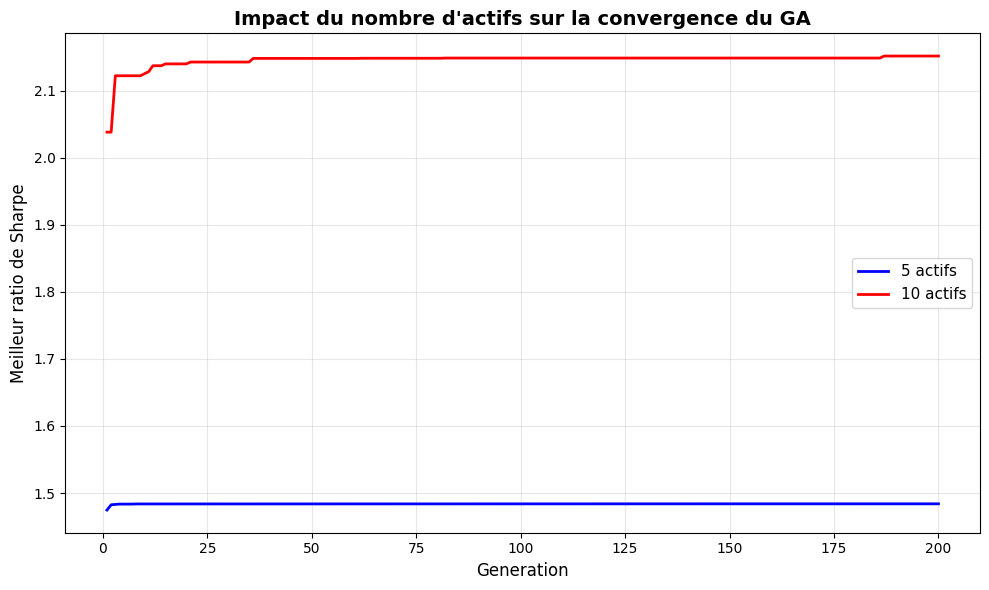

Sharpe final avec 5 actifs  : 1.4839
Sharpe final avec 10 actifs : 2.1516

Observation : avec plus d'actifs, le GA peut mettre plus de generations
a converger car l'espace de recherche est plus grand.


In [16]:
# --- Exercice 3 : 10 actifs ---

n_assets_10 = 10

# Generer des rendements croissants
mu_10 = np.linspace(0.03, 0.30, n_assets_10)

# Generer une matrice de covariance synthetique (definie positive)
# Methode : A * A^T + diag pour garantir la positivite
np.random.seed(123)
A = np.random.randn(n_assets_10, n_assets_10) * 0.05
cov_10 = A @ A.T + np.diag(np.linspace(0.01, 0.06, n_assets_10))

# S'assurer que c'est symetrique
cov_10 = (cov_10 + cov_10.T) / 2


def fitness_10(ga_instance, solution, solution_idx):
    w = np.maximum(np.array(solution), 0)
    total = w.sum()
    if total < 1e-10:
        w = np.ones(n_assets_10) / n_assets_10
    else:
        w = w / total
    ret = w @ mu_10
    risk = np.sqrt(w @ cov_10 @ w)
    if risk < 1e-10:
        return 0.0
    return (ret - risk_free_rate) / risk


# Suivi de convergence pour 5 et 10 actifs
convergence_5 = []
convergence_10 = []

def track_5(ga_inst):
    convergence_5.append(ga_inst.best_solution()[1])

def track_10(ga_inst):
    convergence_10.append(ga_inst.best_solution()[1])

# GA pour 5 actifs (re-execution avec tracking)
convergence_5 = []
ga_5 = pygad.GA(
    num_generations=200, num_parents_mating=10, sol_per_pop=50,
    num_genes=n_assets,
    gene_space=[{"low": 0.0, "high": 1.0}] * n_assets,
    fitness_func=fitness_sharpe,
    parent_selection_type="sss", crossover_type="uniform",
    mutation_type="random", mutation_percent_genes=20,
    on_generation=track_5, suppress_warnings=True,
)
ga_5.run()

# GA pour 10 actifs
convergence_10 = []
ga_10 = pygad.GA(
    num_generations=200, num_parents_mating=10, sol_per_pop=50,
    num_genes=n_assets_10,
    gene_space=[{"low": 0.0, "high": 1.0}] * n_assets_10,
    fitness_func=fitness_10,
    parent_selection_type="sss", crossover_type="uniform",
    mutation_type="random", mutation_percent_genes=20,
    on_generation=track_10, suppress_warnings=True,
)
ga_10.run()

# Comparer les convergences
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, len(convergence_5) + 1), convergence_5,
        'b-', linewidth=2, label='5 actifs')
ax.plot(range(1, len(convergence_10) + 1), convergence_10,
        'r-', linewidth=2, label='10 actifs')
ax.set_xlabel("Generation", fontsize=12)
ax.set_ylabel("Meilleur ratio de Sharpe", fontsize=12)
ax.set_title("Impact du nombre d'actifs sur la convergence du GA",
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

print(f"Sharpe final avec 5 actifs  : {convergence_5[-1]:.4f}")
print(f"Sharpe final avec 10 actifs : {convergence_10[-1]:.4f}")
print(f"\nObservation : avec plus d'actifs, le GA peut mettre plus de generations")
print(f"a converger car l'espace de recherche est plus grand.")

## 8. Conclusion

### Resume

| Concept | Ce que nous avons appris |
|---------|--------------------------|
| **Modele de Markowitz** | Un portefeuille se decrit par un vecteur de poids $\mathbf{w}$, avec rendement $R_p = \mathbf{w}^T\boldsymbol{\mu}$ et risque $\sigma_p = \sqrt{\mathbf{w}^T\Sigma\mathbf{w}}$ |
| **Ratio de Sharpe** | Mesure le rendement ajuste du risque : $S = (R_p - R_f) / \sigma_p$ |
| **Echantillonnage Monte Carlo** | Permet d'explorer l'espace mais sans garantie d'optimalite |
| **GA mono-objectif** | Maximise une fitness unique (Sharpe), convergence rapide et guidee |
| **GA multi-objectif** | L'exploration parametrique par $\alpha$ reconstruit la frontiere efficiente |
| **Contraintes** | Les GA gerent naturellement les contraintes via la normalisation ou la penalisation |

### Liens avec la serie Search

| Notebook | Concept relie |
|----------|---------------|
| Search-5 (GA) | Operateurs genetiques, encodage, fitness |
| App-9 (EdgeDetection) | Autre application des GA (traitement d'images) |
| App-10b (C# version) | Meme probleme avec GeneticSharp |

### Pour aller plus loin

- **NSGA-II** : Algorithme multi-objectif (DEAP) qui produit directement le front de Pareto sans parametrer $\alpha$
- **CVaR** : Mesure de risque alternative (Conditional Value-at-Risk) plus sensible aux queues de distribution
- **Donnees reelles** : Utiliser des rendements historiques d'actions reelles (yfinance, pandas-datareader)
- **Contraintes realistes** : Couts de transaction, lots minimaux, limites sectorielles

### References

- Markowitz, H. (1952). "Portfolio Selection". *The Journal of Finance*, 7(1), 77-91.
- Deb, K. et al. (2002). "A fast and elitist multiobjective genetic algorithm: NSGA-II". *IEEE Transactions on Evolutionary Computation*.
- PyGAD documentation : https://pygad.readthedocs.io

---

**Navigation** : [<< App-9 EdgeDetection](App-9-EdgeDetection.ipynb) | [Index](../README.md) | [App-11 Picross >>](App-11-Picross.ipynb)